In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

Pandas display options to supress scientifc notation and show all columns and all rows if necessary. Puts a lot of strain of processor

In [2]:
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
pd.options.display.float_format= '{:.2f}'.format

In [3]:
nyse = pd.read_csv(os.path.join('Resources', 'nyse.csv'))
nasdaq = pd.read_csv(os.path.join('Resources', 'nasdaq.csv'))
amex = pd.read_csv(os.path.join('Resources', 'amex.csv'))

frames = [nyse, nasdaq, amex]
tickers = pd.concat(frames).sort_values(by='Ticker')

In [4]:
data_2018 = pd.read_csv(os.path.join('Resources', '2018_Financial_Data.csv')).\
rename(columns={'Unnamed: 0':'Ticker'}).\
sort_values(by='Ticker').\
reset_index(drop=True)

df = tickers.merge(data_2018, on='Ticker')

In [5]:
df['Market Cap Size'] = ['Large Cap' if x > 10000000000 else 'Mid Cap' if x > 2000000000 else 'Small Cap' for x in df['Market Cap']]

Note: In *__data_2018__* we had 4392 observations. When we merged with our *__tickers__* dataframe which had 8000+ tickers and company names from exchanges we lost 150 observations. These can be retrieved with 
``` 
data_2018[~data_2018.Ticker.isin(tickers['Ticker'])]
```
Here the **~** symbol essentially means NOT IN when we filter.\
Lastly, a dataframe with just indicators we can manipulate. We can filter out some of the columns containing information we don't need then pass this as a filter to our working dataframe with ```df[x['indicator']]```

In [ ]:
indicators = pd.DataFrame({
   'Indicator': df.iloc[:,2:-3].columns.tolist()
})

x = indicators[indicators['Indicator'].str.contains('Growth|Margin|growth|ratio|Ratio|Turnover|per') == False]

In [ ]:
cond = x['Indicator'].tolist()

## Conditional Filtering

In [ ]:
tickers[tickers['Company Name'].str.contains('S&P') == True];

In [ ]:
df[df['Company Name'].str.contains('Bond') == True];

In [ ]:
df[df['Ticker'].str.startswith('X') == True];

In [ ]:
df[df['Revenue Growth'] > 10].sort_values(by='Revenue', ascending=False).head()

## Graphs and Visualizations

Following two cells achieve the same result by diff methods

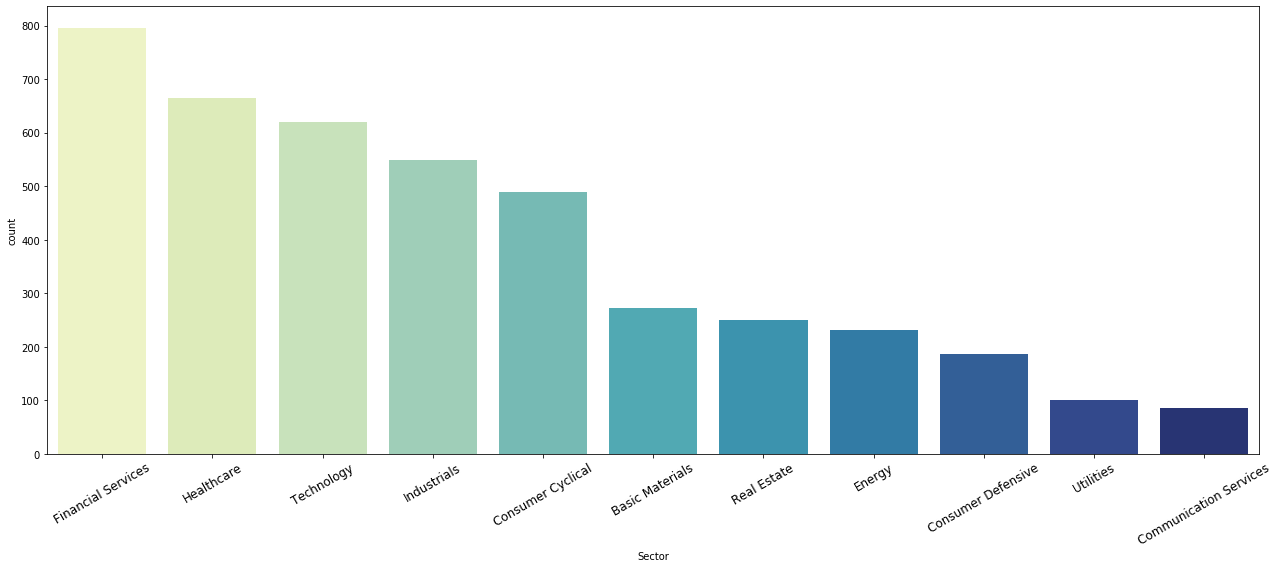

In [8]:
plt.figure(figsize=(18,8))
sns.countplot(x='Sector', data = df, palette='YlGnBu', order=df['Sector'].value_counts().index).set_xticklabels(labels = df['Sector'].value_counts().index, fontdict={'fontsize': 12},rotation=30)
plt.tight_layout()
# plt.savefig(os.path.join('Figures','StockVolume_Sector.png'))

NameError: name 'sector_count' is not defined

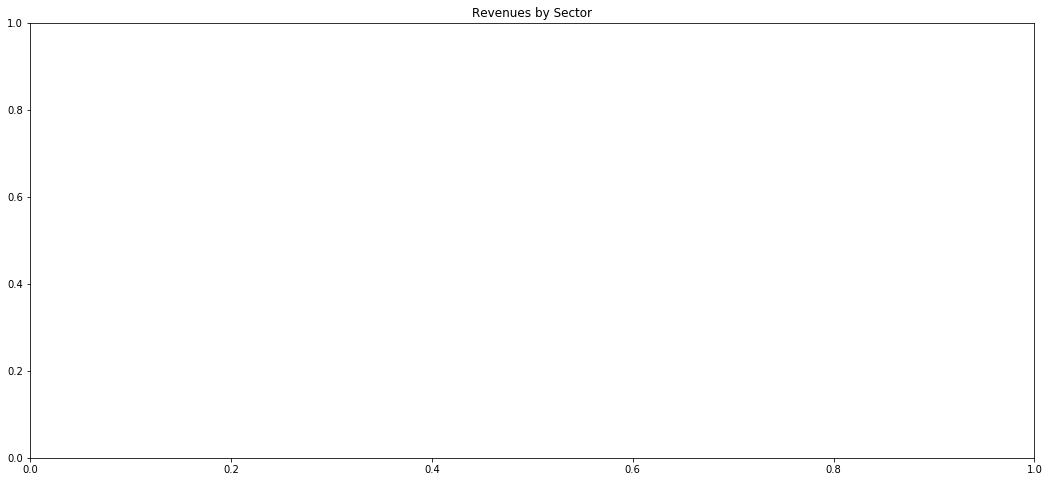

In [10]:
sector_rev = pd.DataFrame(df.groupby(['Sector']).mean()['Revenue']).reset_index().sort_values(by='Revenue', ascending=False)

plt.figure(figsize=(18,8))
plt.title('Revenues by Sector')
sns.barplot(x = sector_rev['Sector'], y = sector_rev['Revenue'], palette='YlGnBu',).set_xticklabels(labels = sector_count['Sector'], fontdict={'fontsize': 12}, rotation=30)
plt.tight_layout();
# plt.savefig(os.path.join('Figures','StockVolume_Sector.png'))

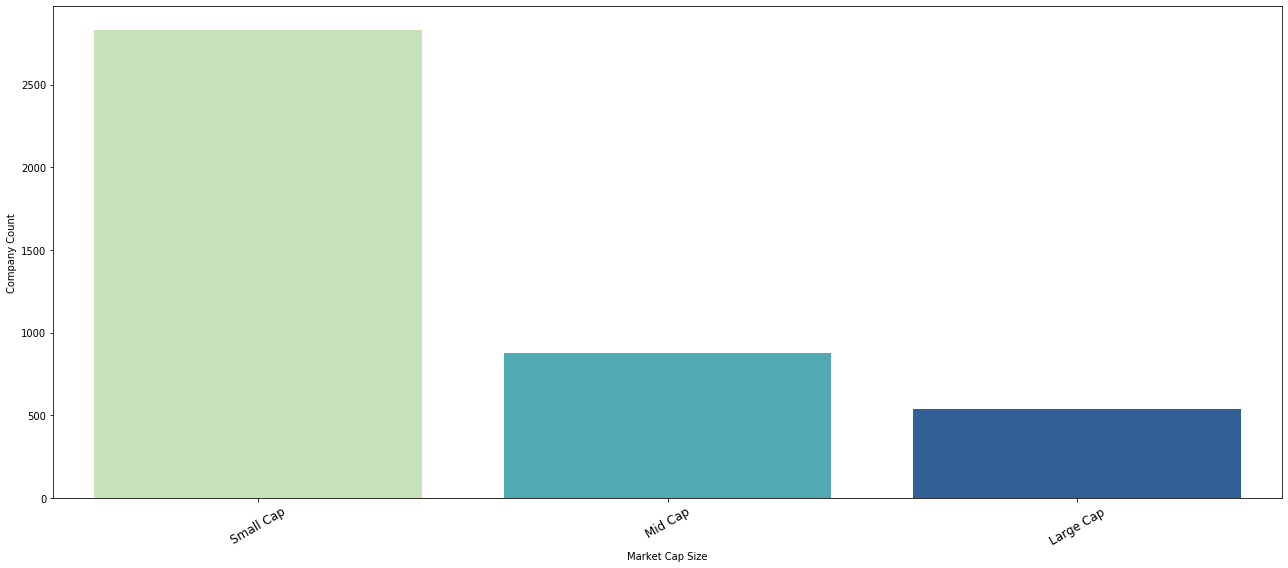

In [26]:
plt.figure(figsize=(18,8))
sns.countplot(x='Market Cap Size', data = df, palette='YlGnBu', order=df['Market Cap Size'].value_counts().index).set_xticklabels(labels = df['Market Cap Size'].value_counts().index, fontdict={'fontsize': 12},rotation=30)
plt.tight_layout()
plt.ylabel('Company Count')
plt.savefig(os.path.join('Figures','MarketCapBreakdown.png'))

In [27]:
pd.DataFrame(df.groupby(['Market Cap Size'])['Sector'].value_counts());

In [29]:
mcap_gen = df.groupby(['Market Cap Size']).__iter__()
sector_gen = df.groupby(['Sector']).__iter__()

In [33]:
group_id, grouped_data = mcap_gen.__next__()
print(group_id) 
grouped_data

Small Cap


,Ticker,Company Name,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class,Market Cap Size
3,AAMC,Altisource Asset,15926000.00,-0.12,0.00,15926000.00,0.00,22534000.00,22534000.00,-6608000.00,...,0.00,-0.18,-0.03,0.00,0.00,-0.12,Financial Services,-58.85,0,Small Cap
4,AAME,Atlantic Amer Cp,185553000.00,0.02,132650000.00,52903000.00,0.00,39042000.00,51837000.00,1066000.00,...,0.00,0.00,-0.09,0.00,0.00,-0.10,Financial Services,-20.25,0,Small Cap
6,AAOI,Applied Optoelect,267465000.00,-0.30,179692000.00,87773000.00,49903000.00,48638000.00,98541000.00,-10768000.00,...,0.23,0.03,-0.04,0.79,0.41,0.11,Technology,-25.19,0,Small Cap
7,AAON,Aaon Inc,433947000.00,0.07,330414000.00,103533000.00,0.00,47755000.00,47743000.00,55790000.00,...,0.10,0.04,0.05,0.00,0.00,-0.03,Basic Materials,41.83,1,Small Cap
10,AAT,American Assets Trust,330867000.00,0.05,121455000.00,209412000.00,0.00,22784000.00,129877000.00,79535000.00,...,0.00,-0.03,-0.04,-0.03,0.00,0.07,Real Estate,19.70,1,Small Cap
11,AAU,Almaden Minerals,0.00,0.00,0.00,0.00,0.00,1428731.85,3482766.67,-3482766.67,...,0.00,0.04,-0.09,0.00,0.00,0.17,Basic Materials,-15.71,0,Small Cap
12,AAWW,Atlas Air Ww,2677724000.00,0.24,1267197000.00,1410527000.00,0.00,702607000.00,1126985000.00,283542000.00,...,0.00,0.12,0.14,0.11,0.00,0.17,Industrials,-33.90,0,Small Cap
18,ABCB,Ameris Bancorp,445137000.00,0.25,0.00,445137000.00,0.00,280727000.00,293647000.00,151490000.00,...,0.00,0.46,0.55,-0.29,0.00,0.25,Financial Services,34.87,1,Small Cap
19,ABEO,Abeona Therapeutics,2998000.00,2.58,0.00,2998000.00,38698000.00,20106000.00,61164000.00,-58166000.00,...,0.00,-0.02,-0.31,0.00,1.28,0.84,Healthcare,-53.49,0,Small Cap
21,ABG,Asbury Automotive Group Inc,6874400000.00,0.06,5771400000.00,1103000000.00,0.00,755800000.00,792100000.00,310900000.00,...,0.29,0.14,0.24,0.16,0.00,0.04,Consumer Cyclical,64.11,1,Small Cap


In [35]:
group_id, grouped_data = sector_gen.__next__()
print(group_id) 
grouped_data

Communication Services


,Ticker,Company Name,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class,Market Cap Size
177,ALSK,Alaska Commun Sys,232468000.00,0.02,107509000.00,124959000.00,0.00,66647000.00,100680000.00,24279000.00,...,-0.04,0.03,0.08,-0.08,0.00,0.00,Communication Services,14.19,1,Small Cap
202,AMOV,America Movil A ADR,52969779642.86,0.02,25960328061.22,27009451581.63,0.00,11591452959.18,19889187755.10,7120263826.53,...,0.04,-0.03,0.05,-0.08,0.00,-0.05,Communication Services,11.66,1,Small Cap
216,AMT,American Tower Corp,7440100000.00,0.12,2177800000.00,5262300000.00,0.00,733200000.00,3357300000.00,1905000000.00,...,0.00,-0.01,-0.17,0.05,0.00,0.15,Communication Services,49.23,1,Large Cap
220,AMX,America Movil S.A.B. DE C.V.,54008000000.00,-0.00,26469000000.00,19438000000.00,nan,11819000000.00,nan,7260000000.00,...,0.04,-0.04,nan,nan,nan,-0.07,Communication Services,11.49,1,Large Cap
329,ATNI,Atn International,451207000.00,-0.06,187509000.00,263698000.00,0.00,139474000.00,202675000.00,61023000.00,...,-0.59,-0.08,0.02,-0.42,0.00,0.01,Communication Services,-22.26,0,Small Cap
343,ATUS,Altice USA Inc Cl A,9566608000.00,0.03,3173076000.00,6393532000.00,0.00,0.00,4711153000.00,1682379000.00,...,0.00,-0.03,-0.36,0.04,0.00,0.00,Communication Services,59.70,1,Large Cap
434,BCE,BCE Inc,17383703703.70,-0.03,10320740740.74,7062962962.96,0.00,0.00,3074074074.07,3988888888.89,...,0.07,-0.04,-0.06,-0.02,0.00,0.00,Communication Services,23.28,1,Large Cap
439,BCOM,B Communications Ltd,2478989361.70,-0.12,0.00,2478989361.70,0.00,1433244680.85,2847074468.09,-368085106.38,...,-0.28,-0.13,-0.83,-0.02,0.00,-0.16,Communication Services,-69.81,0,Small Cap
619,CABO,Cable One Inc,1072295000.00,0.12,370269000.00,702026000.00,0.00,222216000.00,434114000.00,267912000.00,...,0.00,0.04,0.15,-0.01,0.00,0.09,Communication Services,86.66,1,Mid Cap
660,CBB,Cincinnati Bell Inc,1378200000.00,0.29,698700000.00,679500000.00,0.00,313400000.00,596200000.00,83300000.00,...,0.05,0.25,0.42,0.10,0.00,0.33,Communication Services,32.53,1,Small Cap


/Users/danvaldes/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/danvaldes/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


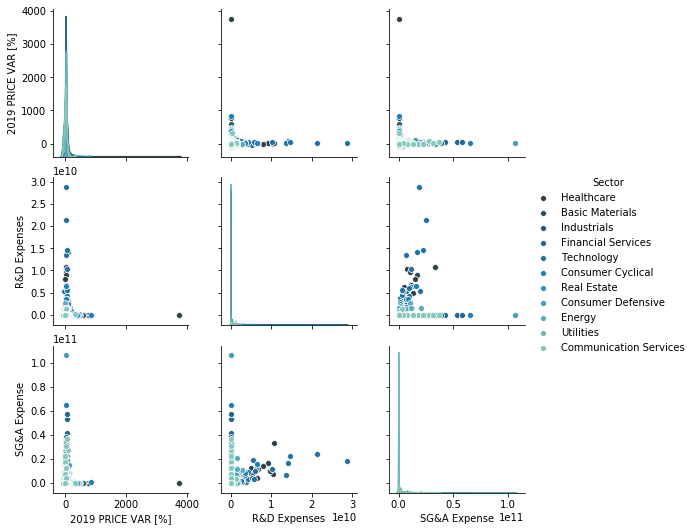

In [32]:
sns.pairplot(df, vars = ['2019 PRICE VAR [%]', 'R&D Expenses', 'SG&A Expense',], dropna = True, hue='Sector', palette='YlGnBu_d')

In [ ]:
corrs = df[cond].corr();

In [ ]:
df.cov();

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(corrs, center=0)

## Regression Analysis

In [ ]:
y = df["2019 PRICE VAR [%]"]

X = sm.add_constant(df[x['Indicator']].fillna(0))

reg = sm.OLS(y, X).fit()

reg.summary();

In [ ]:
# df.to_csv(os.path.join('2018_data.csv'))